# EEB729- Breeding Microbial Communities 3

Ok so this is a corrected notebook, similar to last week. Unlike in previous weeks you will only need to run this once to get all the data required for analysis.

We'd like you all to run it with the same paramaters as we want to confirm that we get the same result across different computers. 

This hopefully should'nt take to long. Remember if you are on a windows change parallel from false to true whenever the .propagate command is used.

Once you have the results, we'd like you to explore how the bottleneck size (b_ext = number of cells transferred)
and migration size (m_ext = number of cells migrated in from the regional species pool) effects the distribution of our community function of interest. You should compare the function of mature parent and offspring communities (i.e at t = 20 and t = 40)

# Load Packages

In [1]:
from IPython.display import Image
from community_simulator import *
from community_simulator.usertools import *
from community_simulator.visualization import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import numpy as np
import scipy as sp
import pandas as pd
colors = sns.color_palette()
%matplotlib inline

# Default Functions

This chunk contains a set of functions and objects that you will need to perform community level selection. We are putting them all together so you can load them once and then they will be available in all subsequent chunks.  You will (hopefully) never need to change any of these functions/objects. 

In [2]:
#Make dynanmics by default we will use the Microbial consumer resource model
def dNdt(N,R,params):
    return MakeConsumerDynamics(assumptions)(N,R,params)
def dRdt(N,R,params):
    return MakeResourceDynamics(assumptions)(N,R,params)
dynamics = [dNdt,dRdt]

# Create a regional species pool
def RegionalSpeciesPool(assumptions):
    # Parameters
    S_tot = int(np.sum(assumptions['SA'])+assumptions['Sgen']) # Total number of species (specialist + generalist)
    F = len(assumptions['SA']) # Number of consumer families
    consumer_names = ['S'+str(k) for k in range(S_tot)]
    family_names = ['F'+str(k) for k in range(F)]
    well_names = ['W'+str(k) for k in range(assumptions['n_wells'])]
    consumer_index = [[family_names[m] for m in range(F) for k in range(assumptions['SA'][m])]
    +['GEN' for k in range(assumptions['Sgen'])],consumer_names]
    
    # Assign drawn values based on power-law distribution
    # Creating an array with M rows an n_wells columns with 0 entries
    pool = np.random.power(1, size  = S_tot) 
    return pool/np.sum(pool)  # Relative species abundance in regional pool

# Sample each communities from a different regional species pool
def SampleFromPools(plate_N, scale=10**9, inocula=10**9):
    S_tot = int(np.sum(assumptions['SA'])+assumptions['Sgen']) # Total number of species (specialist + generalist)
    N0 = np.zeros((plate_N.shape))
    consumer_index = plate_N.index
    well_names = plate_N.columns
    #PA_vector = np.concatenate((np.repeat(0,S_tot - Pool_Size),np.repeat(1,Pool_Size)))
    #np.random.shuffle(PA_vector)
    for k in range(plate_N.shape[1]):
        pool = np.random.power(1, size  = S_tot) #* PA_vector
        pool = pool/np.sum(pool)
        consumer_list = np.random.choice(len(pool), size=inocula, replace=True, p=pool)
        my_tab = pd.crosstab(index=consumer_list, columns="count") # Calculate the cell count
        N0[my_tab.index.values,k] = np.ravel(my_tab.values / scale) # Scale to biomass

    # Make data.frame
    N0 = pd.DataFrame(N0,index=consumer_index,columns=well_names)
    return N0

# Compute the distances from the target resource 
def resource_distance_community_function(plate,R_target,sigma = 0.01): #Sigma is the measurement error
    R_tot = plate.R.shape[0]
    well_tot = plate.R.shape[1]
    relative_resource = np.array(plate.R) #Load plate resource data
    relative_resource[0,:]  = 0.0 #Set supplied resource to 0
    relative_resource = relative_resource/relative_resource.sum(0)  #Look at relative abundance of remaining resource
    R_dist = np.sqrt(np.sum(np.array((np.tile(R_target,(well_tot,1)) - relative_resource.T)**2)[:,1:],axis=1))
    return (np.array(R_dist.T)* -1) * (1+ np.random.normal(0,sigma,well_tot))#(so we select for positive community function)


def mixing_matrix(n_wells,n_mix):
    '''Generates a transfer matrix with the following  rule every community is transfered to itself and combined with 
    n_mix other randomly chosen communities. Mixing is done in equal proportions '''
    TM = np.eye(n_wells)
    for i in range(0,np.shape(TM)[0]):
        r = np.random.choice(np.arange(0,np.shape(TM)[1]-1),n_mix,replace=False)
        for j in r:
            if j < i:
                TM[i,j] = 1
            else:
                TM[i,j+1]  = 1
    return(TM/(n_mix+1))

# Plot community function as a function of time    
def plot_community_function(function_df):
    import matplotlib.pyplot as plt
    #function_df
    time = range(0, len(function_df))
    plt.plot(time,function_df,'ko', markersize=2)
    ax = plt.gca()
    ax.set_xlabel("transfer")
    ax.set_ylabel("Community function")
    plt.show()



## Default Paramaters

To start with we will initalize the paramaters for the system. This section contains the default paramaters
for the simulations. I do not expect you guys to changes these. 

In [3]:
###### Default Paramater values taken from the package 
# NB changing the values here will not change the results of the simultions you need to an equals sign and to 
# Over

sampling:'Binary' #{'Gaussian','Binary','Gamma'} specifies choice of sampling algorithm
SA: 60*np.ones(3) #Number of species in each familyMA': 30*np.ones(3), 
#Number of resources of each type
Sgen: 30 #Number of generalist species
muc: 10 #Mean sum of consumption rates
sigc: 3 #Standard deviation of sum of consumption rates for Gaussian and Gamma models
q: 0.0 #Preference strength (0 for generalist and 1 for specialist)
c0:0.0 #Sum of background consumption rates in binary model
c1:1. #Specific consumption rate in binary model
l:0.8 #Leakage fraction
fs:0.45 #Fraction of secretion flux with same resource type
fw:0.45 #Fraction of secretion flux to 'waste' resource
sparsity:0.2 #Effective sparsity of metabolic matrix
n_wells:10 #Number of independent wells
S:100 #Number of species per well
food:0 #index of food source
R0_food:1000 #unperturbed fixed point for supplied food
regulation:'independent'  #metabolic regulation (see dRdt)
response:'type I' #functional response (see dRdt)
supply:'off' #resource supply (see dRdt)
    

### Paramaters that we will overwrite ###
n_wells = 24
m = 0 #mortality
c1 = 0.01 #Rescale uptake rate part 1. This is needed to avoid numerical errors that slow down the simulations
muc = 0.1 # Rescale uptake part 2
scale = 10**9  #scale is a conversion factor specifying the number of individual microbial cells present when N = 1.
#Set to 10**6 to avoid numerical errors 




### Initialize state of the system ###

# set up default paramater values
assumptions = a_default.copy()
assumptions.update({'n_wells' : n_wells,
                    'm' : 0,
                   'c1' :c1,
                   'muc' :muc,
                   'response' :'type I'})

# Custom paramaters

So now lets define the paramaters that we will be manipulating. For this exercise, you should only have to manipulate the pool_id

In [4]:
#Paramaters that are specific to the simulations we are running. 
ng_pre = 10 #Number of transfers
ng_post = 10
t = 8 #Transfer time 
d_fac  = 1/125 # Dilution factor(i.e what fraction of the community do we transfer.) at every passage
n_inoc =256  #Number of cells sampled from the regional species at start
# To do replicates just repeat the simulation with a different pool_id
pool_id = 1 # The unique ID for each student, changing this ensures that each of you will perform simulations using 
# a different species pool. 


# Generate Target Resource distribution

This bit of code is used to generate a distribution of resources from which the target resource distribution will be sampled.

In [5]:
np.random.seed(0) # Global random seed (i.e all participants)
init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
# Make plate
target_plate = Community(init_state,dynamics,params,parallel=True) # If using mac set parallel to true this speed up your simulations
np.random.seed(0) # Global random seed (i.e all participants)
target_plate.N = SampleFromPools(target_plate.N,inocula=n_inoc) # Populate the well by sampling from a different species pool S_size determines the number of species in each sub-poool
function_df = list() #list of the functions of each community!
for i in range(0, ng_pre):
    target_plate.Propagate(t)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    target_plate.Passage(TM)
target_plate.Propagate(t)
Target_distribution = np.array(target_plate.R.T)[:,1:].flatten()
R_tot = target_plate.R.shape[0]
well_tot = target_plate.R.shape[1]
R_target = np.concatenate([np.zeros(1),np.random.choice(Target_distribution,R_tot-1)])
R_target = R_target/np.sum(R_target)

# Before Reproduction

Set up plate that has some initial variability in function at equilibrium

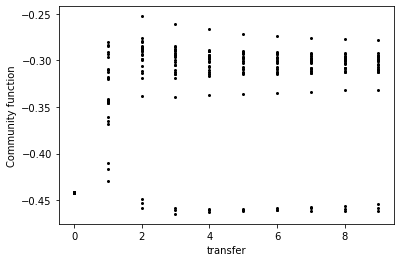

In [6]:
# Set up
np.random.seed(0) # Global random seed (i.e all participants)
init_state = MakeInitialState(assumptions)
params = MakeParams(assumptions)
# Make plate
parent_plate = Community(init_state,dynamics,params,parallel=True) # If using mac set parallel to true this speed up your simulations
np.random.seed(0) # Global random seed (i.e all participants)
parent_plate.N = SampleFromPools(parent_plate.N,inocula=n_inoc) # Populate the well by sampling from a different species pool S_size determines the number of species in each sub-poool
pre = list() #list of the functions of each community!
for i in range(0,ng_pre):
    parent_plate.Propagate(t)
    community_function = resource_distance_community_function(parent_plate, R_target = R_target,sigma=0.001)
    pre.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    parent_plate.Passage(TM)
parent_plate.Propagate(t)
plot_community_function(pre)


Function seems to be uncorrelated to biodiversity at least in small regions

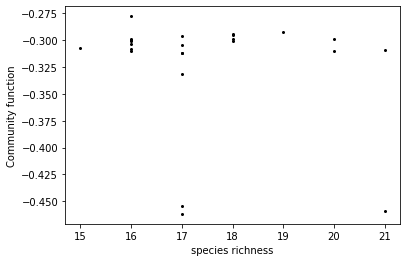

In [7]:
s = np.array(np.sum(parent_plate.N>0))
plt.plot(s,community_function,'ko', markersize=2)
ax = plt.gca()
ax.set_xlabel("species richness")
ax.set_ylabel("Community function")
plt.show()

# Community  Reproduction - Controls

Ok we are going to passage the communities that you have equilibrated using different bottlenecks and migrating different number of cells. To start with we will walk through a few simple examples as a sanity check.

Let start with a ctrl,We'll use a  high b_ext and no migration. We should end up with the same results as before

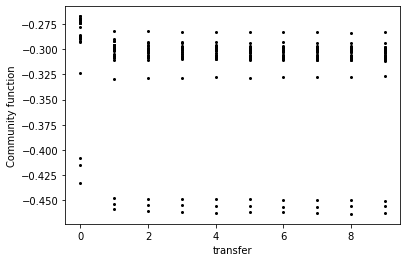

In [8]:
b_ext = 10**6
m_ext  = 0
rs = 0
offspring_plate = parent_plate.copy()
np.random.seed(rs)
TM = np.eye(n_wells) * b_ext/(np.sum(offspring_plate.N.values,axis = 0) * scale) 
offspring_plate.Passage(TM)
if m_ext >0:
    offspring_plate.N =offspring_plate.N + SampleFromPools(parent_plate.N,inocula=m_ext)
#Ok now bring back to equilibrium recording function
post = list()
for i in range(0,ng_post):
    offspring_plate.Propagate(t)
    community_function = resource_distance_community_function(offspring_plate, R_target = R_target,sigma=0.001)
    post.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    offspring_plate.Passage(TM)
plot_community_function(post)

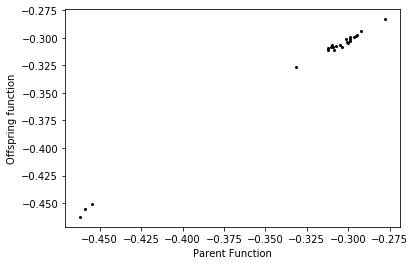

In [9]:
# Extremely high heritability
s = np.array(np.sum(parent_plate.N>0))
plt.plot(pre[-1],post[-1],'ko', markersize=2)
ax = plt.gca()
ax.set_xlabel("Parent Function")
ax.set_ylabel("Offspring function")
plt.show()

Let now introduce a really harsh bottleneck. so that only one cell is passaged.

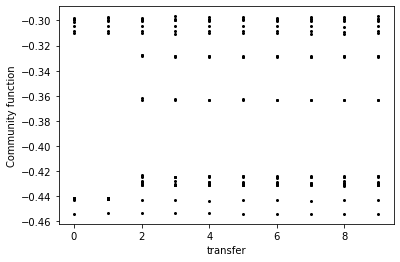

In [10]:
b_ext = 1
m_ext  = 0
rs = 0
offspring_plate = parent_plate.copy()
np.random.seed(rs)
TM = np.eye(n_wells) * b_ext/(np.sum(offspring_plate.N.values,axis = 0) * scale) 
offspring_plate.Passage(TM)
if m_ext >0:
    offspring_plate.N =offspring_plate.N + SampleFromPools(parent_plate.N,inocula=m_ext)
#Ok now bring back to equilibrium recording function
post = list()
for i in range(0,ng_post):
    offspring_plate.Propagate(t)
    community_function = resource_distance_community_function(offspring_plate, R_target = R_target,sigma=0.001)
    post.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    offspring_plate.Passage(TM)
plot_community_function(post)

Let check the number of species in each well at equilibrium. Given that we only passaged 1 cell this should be at
most 1 (which it is)

In [11]:
np.sum(offspring_plate.N>0) 

W0     1
W1     0
W2     0
W3     1
W4     1
W5     1
W6     0
W7     0
W8     1
W9     0
W10    1
W11    1
W12    1
W13    1
W14    1
W15    1
W16    0
W17    1
W18    1
W19    0
W20    0
W21    1
W22    1
W23    1
dtype: int64

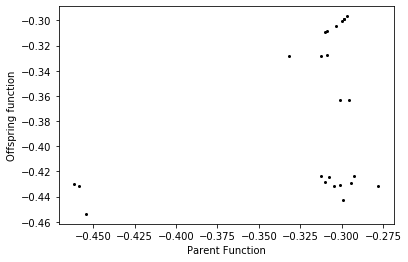

In [12]:
# And therefore Low heritability (but still some.)
s = np.array(np.sum(parent_plate.N>0))
plt.plot(pre[-1],post[-1],'ko', markersize=2)
ax = plt.gca()
ax.set_xlabel("Parent Function")
ax.set_ylabel("Offspring function")
plt.show()

Now we're going migrate as many cells into the community
as we did at the start (from new species pools) and transfer no cells from the parent. This should effectively be a repeat of the initial experiment but with slightly different species pools and samples

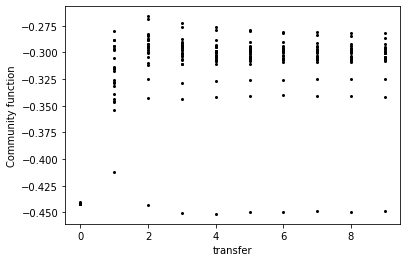

In [13]:
b_ext = 0
m_ext  = n_inoc
rs  =1 
offspring_plate = parent_plate.copy()
np.random.seed(rs)
TM = np.eye(n_wells) * b_ext/(np.sum(offspring_plate.N.values,axis = 0) * scale) 
offspring_plate.Passage(TM)
if m_ext >0:
    offspring_plate.N =offspring_plate.N + SampleFromPools(parent_plate.N,inocula=m_ext)
#Ok now bring back to equilibrium recording function
post = list()
for i in range(0,ng_post):
    offspring_plate.Propagate(t)
    community_function = resource_distance_community_function(offspring_plate, R_target = R_target,sigma=0.001)
    post.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    offspring_plate.Passage(TM)
plot_community_function(post)

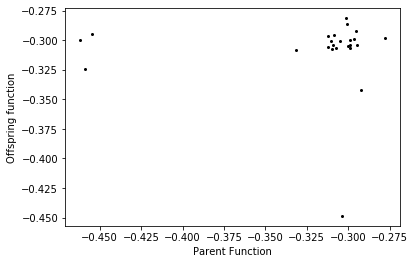

In [14]:
# And no heritability the communities are all new. 
s = np.array(np.sum(parent_plate.N>0))
plt.plot(pre[-1],post[-1],'ko', markersize=2)
ax = plt.gca()
ax.set_xlabel("Parent Function")
ax.set_ylabel("Offspring function")
plt.show()

Now we're going migrate only a single cell into the pool

/Users/chang-yu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


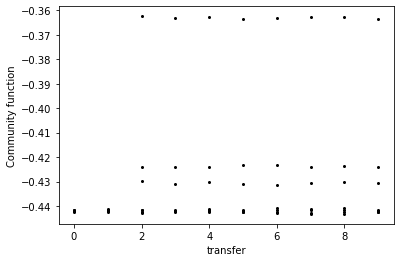

In [15]:
b_ext = 0
m_ext  = 1
rs  =1 
offspring_plate = parent_plate.copy()
np.random.seed(rs)
TM = np.eye(n_wells) * b_ext/(np.sum(offspring_plate.N.values,axis = 0) * scale) 
offspring_plate.Passage(TM)
if m_ext >0:
    offspring_plate.N =offspring_plate.N + SampleFromPools(parent_plate.N,inocula=m_ext)
#Ok now bring back to equilibrium recording function
post = list()
for i in range(0,ng_post):
    offspring_plate.Propagate(t)
    community_function = resource_distance_community_function(offspring_plate, R_target = R_target,sigma=0.001)
    post.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    offspring_plate.Passage(TM)
plot_community_function(post)

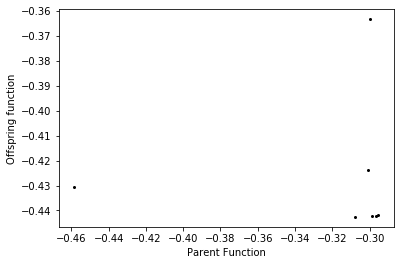

In [16]:
# And no heritability at all (in fact in this case most communities show no growth)
s = np.array(np.sum(parent_plate.N>0))
plt.plot(pre[-1],post[-1],'ko', markersize=2)
ax = plt.gca()
ax.set_xlabel("Parent Function")
ax.set_ylabel("Offspring function")
plt.show()

Were going to test out the mixing, Lets mix every well with 10 other wells

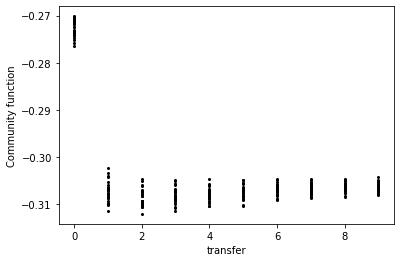

In [17]:
b_ext = 10**6
m_ext  = 0
r_ext = 10
rs = 0
offspring_plate = parent_plate.copy()
np.random.seed(rs)
TM2 = mixing_matrix(n_wells,r_ext)
offspring_plate.Passage(TM2)

TM = np.eye(n_wells) * b_ext/(np.sum(offspring_plate.N.values,axis = 0) * scale)
offspring_plate.Passage(TM)
if m_ext >0:
    offspring_plate.N =offspring_plate.N + SampleFromPools(parent_plate.N,inocula=m_ext)
#Ok now bring back to equilibrium recording function
post = list()
for i in range(0,ng_post):
    offspring_plate.Propagate(t)
    community_function = resource_distance_community_function(offspring_plate, R_target = R_target,sigma=0.001)
    post.append(community_function)
    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
    offspring_plate.Passage(TM)
plot_community_function(post)

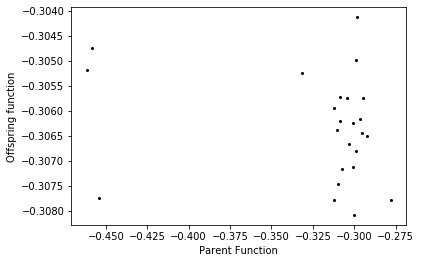

In [18]:
# Low Heritability
s = np.array(np.sum(parent_plate.N>0))
plt.plot(pre[-1],post[-1],'ko', markersize=2)
ax = plt.gca()
ax.set_xlabel("Parent Function")
ax.set_ylabel("Offspring function")
plt.show()

# The experiment  
Ok now lets that we have confirmed that every works lets run many simulations vary an obscence number of paramaters and and save all the data.

save_df = pd.DataFrame()
for rs in range(0,20):
    np.random.seed(rs)
    for r_ext in [0,1,2,3,4,5,6,7,8,9]:
        for m_ext in [0,1,2,4,8,16,32,64,128,256,512,1024]:
            for b_ext in [0,1,2,4,8,16,32,64,128,256,512,1024]:
                offspring_plate = parent_plate.copy()
                if r_ext >0:
                    TM2 = mixing_matrix(n_wells,r_ext)
                    offspring_plate.Passage(TM2)
                TM = np.eye(n_wells) * b_ext/(np.sum(offspring_plate.N.values,axis = 0) * scale) 
                offspring_plate.Passage(TM)
                if m_ext >0:
                    offspring_plate.N =offspring_plate.N + SampleFromPools(parent_plate.N,inocula=m_ext)
                #Ok now bring back to equilibrium recording function
                post = list()
                for i in range(0,ng_post):
                    offspring_plate.Propagate(t)
                    community_function = resource_distance_community_function(offspring_plate, R_target = R_target,sigma=0.01)
                    post.append(community_function)
                    TM = np.eye(n_wells)*d_fac  #Generate transfer matrix (in this case we are just transfering like to like so it's the identiy matrix *dilution factor)        
                    offspring_plate.Passage(TM)
                offspring_plate.Propagate(t)
                full = pd.DataFrame(pre+post)
                full['Timepoint'] = full.index
                full = pd.melt(full,id_vars=['Timepoint'], var_name = 'Community_ID',value_name = 'Measured_Function')
                full['Pool_Random_Seed']  = pool_id
                full['Bottleneck_Size']  = b_ext
                full['Migration_Size'] = m_ext
                full['Recombination_number'] = r_ext
                full['Replicate']  = rs 
                full['Inoculum Size']  = n_inoc
                save_df = save_df.append(full)
                save_df.to_csv('Data/Full_Dataset.csv') #
            #Saves data each time simulation is done running
            #Ok so were going to overnight the nan with the minimum function (I.e the function when there is no community)



In [19]:
#Ok now lets also the effect of reecombination